<a href="https://colab.research.google.com/github/hamzajb95/CE888/blob/main/Lab3/Lab_3_bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Data Classifier

## Importing Libraries & Loading Data

In [1]:
# Importing Libraries 

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics

In [2]:
# Loading Data

data = pd.read_csv('https://raw.githubusercontent.com/neerajthandayan/Misc./main/Lab_3/bank-additional-full.csv',delimiter=';')
data.drop(columns='duration',inplace=True)
data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Exploratuon & Pre-processing

In [3]:
# Check for NaN values in Dataset

print(data.isnull().values.any(),data.isnull().sum().sum())

False 0


In [4]:
# Apply One-Hot Encoding to the Categorical Features

data = pd.get_dummies(data, columns=['job','marital','default','education',
                                           'housing','loan','contact','month',
                                           'day_of_week','poutcome'])

In [5]:
# Label encoding for the Labels given in dataset 

le = LabelEncoder()
data['y'] = le.fit_transform(data['y'])

In [6]:
# Seperate the features from the label for future train test split

target = data['y'].values 
feature = data.drop(columns='y').copy().values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'No'), Text(0, 0, 'Yes')]

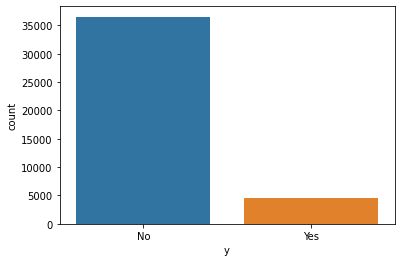

In [7]:
# PLotting Histogram of Label

plot = sns.countplot(data['y'])
plot.set_xticklabels(['No','Yes'])

In [8]:
# Calculating Data Imbalance

cnt = np.unique(data['y'],return_counts=True)
imbalance = cnt[1][1]/cnt[1][0]
print(f'Dataset Imbalance: {imbalance}')

Dataset Imbalance: 0.126956331399803


In [9]:
# Creating Test-Train Split

feat_train, feat_test, target_train, target_test = train_test_split(feature, target, test_size=0.2, random_state=50 ,stratify=target)

## Cross-validation & Dummy Classifier Test

In [10]:
# K-Fold Cross Validation

clf = RandomForestClassifier(n_estimators=100, max_depth=3)
cv_acc = cross_validate(clf, feat_train, target_train, cv=10, scoring='accuracy')
cv_f1 = cross_validate(clf, feat_train, target_train, cv=10, scoring='f1')

In [11]:
# Cross Validation Data

acc = round(cv_acc['test_score'].mean()*100,2)
f1 = cv_f1['test_score'].mean()
print(f'Mean Accuracy: {acc}%\nMean F1-Score: {f1}')

Mean Accuracy: 89.79%
Mean F1-Score: 0.24667004115727176


In [14]:
# Running Classifier on Data

clf.fit(feat_train, target_train)
j = {'feature' : data.drop(columns='y').columns.copy(), 'importance' : clf.feature_importances_}
df = pd.DataFrame.from_dict(j)
df = df.sort_values(by='importance',ascending=False)
df.head(3)

,feature,importance
8,nr.employed,0.185403
7,euribor3m,0.177953
2,pdays,0.131090


<BarContainer object of 10 artists>

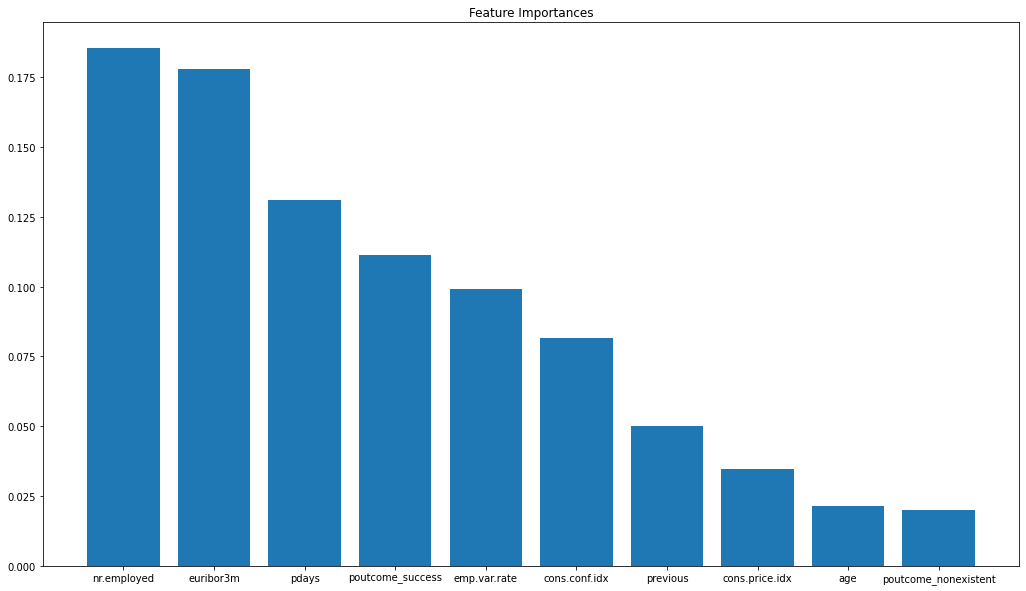

In [15]:
# Plotting Fearure Importance

top10 = df.head(10)
fig = plt.figure(figsize=(17.5,10))
plt.title("Feature Importances")
plt.bar(top10['feature'],top10['importance'])

In [19]:
# Evaluating Model

ypred = clf.predict(feat_test)
print(f'Accuracy: {round(metrics.accuracy_score(ypred,target_test)*100,2)}%\n')
print(metrics.confusion_matrix(ypred,target_test))

Accuracy: 90.0%

[[7246  760]
 [  64  168]]


In [26]:
# Comparing with Dummy Classifier

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(feat_train, target_train)
dummy_clf.predict(feat_train)
print(f'Dummy Classifier Accuracy: {dummy_clf.score(feat_train,target_train)*100}%')

Dummy Classifier Accuracy: 79.88467374810318%


## Setting Up GridSearch

In [27]:
estimator = RandomForestClassifier(n_estimators=100, max_depth=3)
param_grid = {'n_estimators':[100, 500 ,1000],
              'max_depth': [3, 9, 27]}

GS_f1 = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)

In [29]:
# Fitting GridSearch Objects

optclf_f1 = GS_f1.fit(feat_train, target_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [30]:
optclf_f1.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=27, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
bpred = optclf_f1.best_estimator_.predict(feat_test)

In [34]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cnf_matrix = confusion_matrix(target_test, bpred)
cnf_acc = accuracy_score(target_test, bpred)
np.set_printoptions(precision=2)
print(f'Confusion Matrix:\n{cnf_matrix}\nAccuracy Score: {round(cnf_acc*100,2)}%')

Confusion Matrix:
[[7082  228]
 [ 648  280]]
Accuracy Score: 89.37%
